####  **Import Libraries and modules**

In [0]:
import numpy as np
import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D
from keras.optimizers import Adam, SGD
from keras import backend as k
from keras.utils import np_utils

from keras.datasets import mnist, cifar10

### Load pre-shuffled CIFAR data into train and test sets
Plotting sample images from the dataset 

170500096/170498071 [==============================] - 4s 0us/step


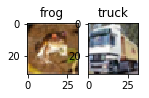

In [0]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# X_train - 50000, 32, 32, 3
label_dict = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

from matplotlib import pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(2,2)) # width,height

for idx in range(2):
  sub = fig.add_subplot(1,2, idx+1) # nrows, ncols, index
  label = label_dict.get(y_train[idx][0])
    
  sub.set_title(label)
  sub.imshow(X_train[idx])

One hot encoding the labels from training and test set. Each 1d label is converted to 10d sparse matrix. Eg, digit 2 becomes [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
print(Y_train.shape)

(50000, 10)


#### 2 models with dropout and BN:

* 32-64-128-MP-100-128-256-512-MP-200(1)-100-10. 1.83m params. Best val. accuracy was **78.28% at epoch 19**, train acc 95.49%
* 48-96-64(1)-MP-96-192-128(1)-MP-192-384-200(1)-MP-100-10. 1.3m params. Best val. accuracy **82.77% at epoch 19**, train acc 95.21%

Second model is chosen


In [0]:
def build_first_model():
  model = Sequential()
  model.add(Conv2D(32, 3, activation='relu', input_shape=(32,32,3), use_bias=False))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  
  model.add(Conv2D(64, 3, activation='relu', use_bias=False)) #rf5, 28
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  
  model.add(Conv2D(128, 3, activation='relu', use_bias=False))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  
  model.add(MaxPooling2D(pool_size=(2, 2)))    # #rf14, 13 
  model.add(Conv2D(100, 1, activation='relu'))
 
  model.add(Conv2D(128, 3, activation='relu', use_bias=False))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  
  model.add(Conv2D(256, 3, activation='relu', use_bias=False))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  
  model.add(Conv2D(512, 3, activation='relu', use_bias=False))  #rf20, 7
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
    
  model.add(MaxPooling2D(pool_size=(2, 2)))    #rf40, 3
  model.add(Conv2D(200, 1, activation='relu'))
  model.add(Conv2D(100, 1, activation='relu'))
    
  model.add(Conv2D(10, 3))
  model.add(Flatten())
  model.add(Activation('softmax'))
  return model

In [0]:
model=build_first_model()
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=1,
          validation_data=(X_test, Y_test))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 30, 30, 32)        864       
_________________________________________________________________
batch_normalization_25 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
dropout_25 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 28, 28, 64)        18432     
_________________________________________________________________
batch_normalization_26 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
dropout_26 (Dropout)         (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 26, 26, 128)      

In [0]:
def build_second_model():
  model = Sequential()
  
  model.add(Conv2D(48, 3, padding='same', input_shape=(32, 32, 3), use_bias=False)) #rf 3
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Conv2D(96, 3, padding='same', use_bias=False)) 
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  
  model.add(Conv2D(64, 1 ))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2))) #16, rf10  

  model.add(Conv2D(96, 3, padding='same', use_bias=False))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Conv2D(192, 3, padding='same', use_bias=False)) #16, rf14
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  
  model.add(Conv2D(128, 1))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2))) #8, rf28
  
  model.add(Conv2D(192, 3, padding='same', use_bias=False))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Conv2D(384, 3, padding='same', use_bias=False))#8, rf32
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  
  model.add(Conv2D(200, 1))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2))) #4, rf64
   
  model.add(Conv2D(100, 1))
  model.add(Activation('relu'))
  model.add(Conv2D(10, 4))
    
  model.add(Flatten())
  model.add(Activation('softmax'))
  return model

In [0]:
model=build_second_model()
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=1,
          validation_data=(X_test, Y_test))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 32, 32, 48)        1296      
_________________________________________________________________
activation_24 (Activation)   (None, 32, 32, 48)        0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 48)        192       
_________________________________________________________________
dropout_19 (Dropout)         (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 32, 32, 96)        41472     
_________________________________________________________________
activation_25 (Activation)   (None, 32, 32, 96)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 32, 32, 96)       

#### Using depthwise sep conv in place of normal, parameters dropped to 267K from 1.3m. Best val. accuracy was **81.77% at epoch 20**, train acc 89.54%. Gap between 2 accuracies have reduced as overfitting has reduced.

In [0]:
def build_depth_sep():
  model = Sequential()
  
  model.add(SeparableConv2D(48, 3, padding='same', input_shape=(32, 32, 3), use_bias=False)) #rf 3
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(SeparableConv2D(96, 3, padding='same', use_bias=False)) 
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  
  model.add(SeparableConv2D(64, 1 ))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2))) #16, rf10  

  model.add(SeparableConv2D(96, 3, padding='same', use_bias=False))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(SeparableConv2D(192, 3, padding='same', use_bias=False)) #16, rf14
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  
  model.add(SeparableConv2D(128, 1))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2))) #8, rf28
  
  model.add(SeparableConv2D(192, 3, padding='same', use_bias=False))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(SeparableConv2D(384, 3, padding='same', use_bias=False))#8, rf32
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  
  model.add(SeparableConv2D(200, 1))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2))) #4, rf64
   
  model.add(SeparableConv2D(100, 1))
  model.add(Activation('relu'))
  model.add(SeparableConv2D(10, 4))
    
  model.add(Flatten())
  model.add(Activation('softmax'))
  return model

In [0]:
model=build_depth_sep()
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=1,
          validation_data=(X_test, Y_test))

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_69 (Separab (None, 32, 32, 48)        171       
_________________________________________________________________
activation_156 (Activation)  (None, 32, 32, 48)        0         
_________________________________________________________________
batch_normalization_144 (Bat (None, 32, 32, 48)        192       
_________________________________________________________________
dropout_144 (Dropout)        (None, 32, 32, 48)        0         
_________________________________________________________________
separable_conv2d_70 (Separab (None, 32, 32, 96)        5040      
_________________________________________________________________
activation_157 (Activation)  (None, 32, 32, 96)        0         
_________________________________________________________________
batch_normalization_145 (Bat (None, 32, 32, 96)      

In [0]:
def spatial_sep_conv(model, filter_x, filter_out):
    l1 = Conv2D(filter_x, (3, 1), activation='relu', padding='same')
    model.add(l1)
    l2 = Conv2D(filter_out, (1,3), activation='relu', padding='same')    
    model.add(l2)
    
    #l1 type keras.layers.convolutional.Conv2D
    #print(l1.output_shape, l2.output_shape)
    
    return model

#### Using spatial sep conv in place of normal, parameters dropped to 740K from 1.3m. Best val. accuracy was **81.05% at epoch 19**, train acc 91.77%.
Here paramaters are more than depthwise sep, hence overfitting is slightly more. Depthwise is used mostly.

In [0]:
def build_spatial_sep_model():
  model = Sequential()
  
  model.add(Conv2D(48, 3, padding='same', activation='relu', input_shape=(32, 32, 3))) #rf 3
  #model = spatial_sep_conv2(model, 3, 48, input_shape=(32, 32, 3))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model = spatial_sep_conv2(model, 48, 96)
  model.add(BatchNormalization())
  model.add(Dropout(0.1))  
  
  model.add(Conv2D(64, 1, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2))) #16, rf10  
  
  model = spatial_sep_conv2(model, 64, 96)
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model = spatial_sep_conv2(model, 96, 192) #16, rf14
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  
  model.add(Conv2D(128, 1, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2))) #8, rf28
  
  model = spatial_sep_conv2(model, 128, 192)
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model = spatial_sep_conv2(model, 192, 384) #8, rf32
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  
  model.add(Conv2D(200, 1, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2))) #4, rf64
    
  model.add(Conv2D(100, 1, activation='relu'))
  model.add(Conv2D(10, 4))
    
  model.add(Flatten())
  model.add(Activation('softmax'))
  return model

In [0]:
model=build_spatial_sep_model()
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=1,
          validation_data=(X_test, Y_test))

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_228 (Conv2D)          (None, 32, 32, 48)        1344      
_________________________________________________________________
batch_normalization_138 (Bat (None, 32, 32, 48)        192       
_________________________________________________________________
dropout_138 (Dropout)        (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_229 (Conv2D)          (None, 32, 32, 48)        6960      
_________________________________________________________________
conv2d_230 (Conv2D)          (None, 32, 32, 96)        13920     
_________________________________________________________________
batch_normalization_139 (Bat (None, 32, 32, 96)        384       
_________________________________________________________________
dropout_139 (Dropout)        (None, 32, 32, 96)      